In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import random
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Load the mapping for label and the emoji
mapping = pd.read_csv("data/Mapping.csv")
mapping = mapping.drop("Unnamed: 0", axis=1)
mapping = mapping.set_index('number')
emoji_dict = mapping.to_dict()
emoji_dict = emoji_dict['emoticons']
emoji_dict

{0: '😜',
 1: '📸',
 2: '😍',
 3: '😂',
 4: '😉',
 5: '🎄',
 6: '😎',
 7: '🔥',
 8: '😘',
 9: '❤',
 10: '😁',
 11: '🇺🇸',
 12: '☀',
 13: '✨',
 14: '😊',
 15: '💯'}

In [3]:
#Load the training dataset
full_dataset = pd.read_csv('data/Train.csv')
full_dataset.dropna(inplace=True) #Remove missing values
# full_dataset=full_dataset.head(3000)
print(full_dataset.head())
total_no_of_rows=full_dataset['TEXT'].size
maxLen = 20 #This is the maximum number of words in a sentence.
print(total_no_of_rows)

   Unnamed: 0                                               TEXT  Label
0           0  Vacation wasted ! #vacation2017 #photobomb #ti...      0
1           1  Oh Wynwood, you’re so funny! : @user #Wynwood ...      1
2           2  Been friends since 7th grade. Look at us now w...      2
3           3  This is what it looks like when someone loves ...      3
4           4  RT @user this white family was invited to a Bl...      3
3000


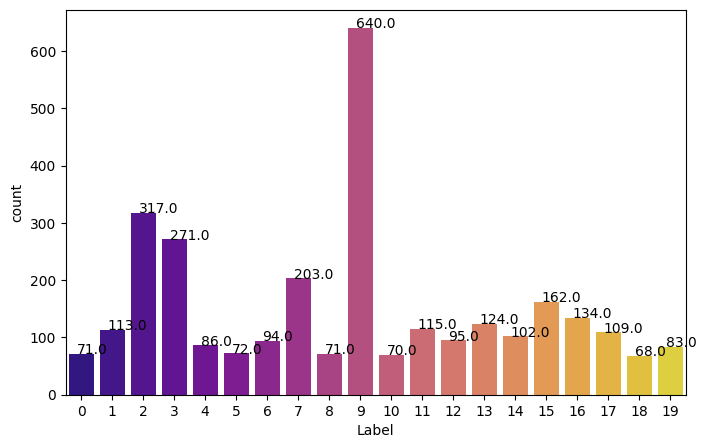

In [4]:
df = pd.DataFrame()
df['Text']=full_dataset['TEXT']
df['Label']=full_dataset['Label']
plt.figure(figsize=(8,5))
ax=sns.countplot(x="Label", data=df, palette="plasma")
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

In [5]:
#Remove same meaning emojis
df.drop(df[df.Label == 6].index, inplace=True)
df.drop(df[df.Label == 14].index, inplace=True)
df.drop(df[df.Label == 15].index, inplace=True)
df.drop(df[df.Label == 18].index, inplace=True)

In [6]:
#update the labels since 4 classes are removed.
df['Label'] = np.where(df['Label'] == 16, 6, df['Label'])
df['Label'] = np.where(df['Label'] == 17, 14, df['Label'])
df['Label'] = np.where(df['Label'] == 19, 15, df['Label'])

In [7]:
nine_indx= df.index[(df.Label == 9) == True].tolist()
removing_nine_indx=random.sample(nine_indx, int(0.15*total_no_of_rows))

two_indx= df.index[(df.Label == 2) == True].tolist()
removing_two_indx=random.sample(two_indx, int(0.04*total_no_of_rows))

three_indx= df.index[(df.Label == 3) == True].tolist()
removing_three_indx=random.sample(three_indx, int(0.04*total_no_of_rows))

In [8]:
#Since the dataset is biased to certain class, we removed random records from that class to normalize the dataset.
df.drop(index=removing_nine_indx,inplace=True)
df.drop(index=removing_two_indx,inplace=True)
df.drop(index=removing_three_indx,inplace=True)

In [9]:
df.reset_index(inplace=True, drop=True)

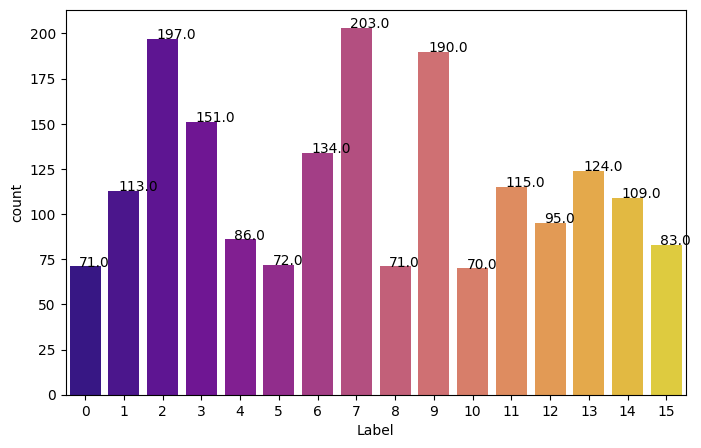

In [10]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x="Label", data=df, palette="plasma")
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

In [11]:
df.describe()

,Label
count,1884.000000
mean,7.247877
std,4.418450
min,0.000000
25%,3.000000
50%,7.000000
75%,11.000000
max,15.000000


In [12]:
X_full_dataset=df['Text']
Y_full_dataset=df['Label']
print(X_full_dataset.shape,Y_full_dataset.shape)

(1884,) (1884,)


In [14]:
#open the glove file and get the coefficent for each word
glove = open('glove.6B.50d.txt')
glove_embedding={}

for sentence in glove:
  words = sentence.split()
  word = words[0]
  coef = np.asarray(words[1:],dtype='float')
  glove_embedding[word]=coef

In [15]:
print(glove_embedding['happy'])
print(glove_embedding['happy'].shape)

[ 0.092086  0.2571   -0.58693  -0.37029   1.0828   -0.55466  -0.78142
  0.58696  -0.58714   0.46318  -0.11267   0.2606   -0.26928  -0.072466
  1.247     0.30571   0.56731   0.30509  -0.050312 -0.64443  -0.54513
  0.86429   0.20914   0.56334   1.1228   -1.0516   -0.78105   0.29656
  0.7261   -0.61392   2.4225    1.0142   -0.17753   0.4147   -0.12966
 -0.47064   0.3807    0.16309  -0.323    -0.77899  -0.42473  -0.30826
 -0.42242   0.055069  0.38267   0.037415 -0.4302   -0.39442   0.10511
  0.87286 ]
(50,)


In [16]:
#Embedding function which will convert our words to Glove embeddings
def embed_my_words(X):
    full_embedding = np.zeros((len(X), maxLen, 50))
    
    for sentence_index in range(X.shape[0]):
        sentence = X[sentence_index].split()
        
        for ij in range(len(sentence)): 
            if (glove_embedding.get(sentence[ij].lower()) is not None) and (ij<maxLen):
                full_embedding[sentence_index][ij] = glove_embedding[sentence[ij].lower()]
            
    return full_embedding

In [17]:
#Convert out entire dataset to embedding vectors
full_dataset_embed = embed_my_words(X_full_dataset)
print(full_dataset_embed.shape)


(1884, 20, 50)


In [18]:
#Run only once
#Convert our labels to categorical values
y_full_dataset_cat = to_categorical(Y_full_dataset,num_classes=16)
print(y_full_dataset_cat.shape)

(1884, 16)


In [20]:
full_dataset_embed = full_dataset_embed.reshape(-1, maxLen*50)

(1884, 1000)


In [21]:
#We balance the class if one class is imbalanced
oversample = SMOTE()
oversampled_X, oversampled_Y = oversample.fit_resample(full_dataset_embed, y_full_dataset_cat)

In [22]:
oversampled_X = oversampled_X.reshape(-1, maxLen, 50)
oversampled_X.shape, oversampled_Y.shape

((3248, 20, 50), (3248, 16))

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(oversampled_X, oversampled_Y, test_size=0.2, random_state=42)

In [24]:
#Creating the model
model = Sequential()
model.add(Bidirectional(LSTM(units = 512, return_sequences=True), input_shape = (maxLen,50)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=16, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 1024)         2306048   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 1024)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              2623488   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 16)                2

In [25]:
# Delete saved model first
# Train the model

#Run for 40 epochs and save the best model
keras_callbacks   = [
      ModelCheckpoint("best_model_glove_bidirectional_2_layer.h5", monitor='val_loss', save_best_only=True, mode='min')
]
model.compile(loss = 'categorical_crossentropy',
             optimizer = "adam",
             metrics=["accuracy"])
model.fit(X_train, Y_train, batch_size=64, epochs = 40, shuffle=True,
          validation_split=0.2, callbacks=[keras_callbacks])

Epoch 1/40


2022-12-20 19:19:26.590266: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 13s 299ms/step - loss: 2.7435 - accuracy: 0.1030 - val_loss: 2.6400 - val_accuracy: 0.1558
Epoch 2/40
33/33 [==============================] - 10s 299ms/step - loss: 2.5861 - accuracy: 0.1732 - val_loss: 2.5448 - val_accuracy: 0.1865
Epoch 3/40
33/33 [==============================] - 10s 297ms/step - loss: 2.4418 - accuracy: 0.2310 - val_loss: 2.4417 - val_accuracy: 0.2519
Epoch 4/40
33/33 [==============================] - 9s 283ms/step - loss: 2.2902 - accuracy: 0.2974 - val_loss: 2.3477 - val_accuracy: 0.2654
Epoch 5/40
33/33 [==============================] - 9s 283ms/step - loss: 2.0767 - accuracy: 0.3662 - val_loss: 2.2833 - val_accuracy: 0.2981
Epoch 6/40
33/33 [==============================] - 10s 293ms/step - loss: 1.8653 - accuracy: 0.4278 - val_loss: 2.1786 - val_accuracy: 0.3231
Epoch 7/40
33/33 [==============================] - 10s 306ms/step - loss: 1.6872 - accuracy: 0.4793 - val_loss: 2.0465 - val_accuracy: 0.3885
Epoch 8/40
3

In [26]:
def emojiPredict(text):
    return emoji_dict[np.argmax(model.predict(embed_my_words(np.asarray([text]))))]

In [27]:
model.load_weights("best_model_glove_bidirectional_2_layer.h5")
loss,accuracy=model.evaluate(X_test, Y_test, batch_size=64)
predicted_y=model.predict(X_test)
print('Precision {}'.format(precision_score(np.argmax(Y_test,axis=1), np.argmax(predicted_y,axis=1) , average="macro")))
print('Recall {}'.format(recall_score(np.argmax(Y_test,axis=1), np.argmax(predicted_y,axis=1) , average="macro")))
print('F1 score {}'.format(f1_score(np.argmax(Y_test,axis=1), np.argmax(predicted_y,axis=1) , average="macro")))
print('Loss {}'.format(loss))
print('Accuracy {}'.format(accuracy))

21/21 [==============================] - 2s 46ms/step
Precision 0.4082931239625629
Recall 0.3880382863050026
F1 score 0.3819858878569241
Loss 2.164065361022949
Accuracy 0.38461539149284363


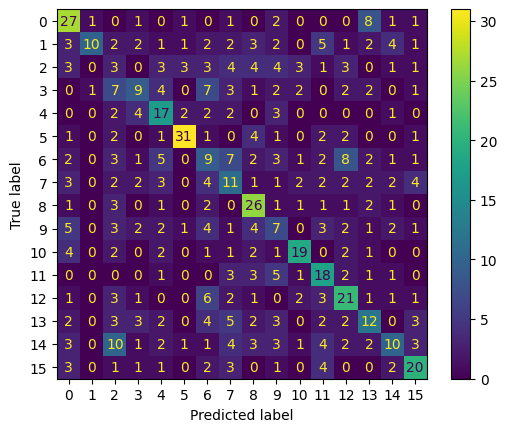

In [28]:
cm = confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(predicted_y,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()